# Song Popularity Prediction 
## Data Preparation, Pipelines & Model Notebook
Dit notebook automatiseert de stappen uit de data exploratie notebook. 
Doel van dit notebook: onderzoeken in hoeverre audiofeatures (zoals danceability, valence, energy) de populariteit van een nummer kunnen voorspellen.  
Gebruikte dataset: https://www.kaggle.com/datasets/yasserh/song-popularity-dataset

<style>
#index ul {
    font-size: 97%;
}
</style>
<div id="index">

# Index 
- 1. [Phase 1: Business Understanding](#1-business-understanding)
- 3. [Phase 3: Data Preparation](#data-prep)
    - 3.1 [Handmatige data cleaning](#data_cleaning)
    - 3.2 [Cyclische Encoder en Outlier Cleaner](#custom_functions)
        - 3.2.1 [Toonsoort Cyclische Encoder](#cyclic)
        - 3.2.2 [Outlier Cleaner class](#outliers)
    - 3.3 [Nieuwe Features](#nieuwe_features)
    - 3.4 [Train-test split](#traintest)
    - 3.5 [Preprocessor](#preprocessor)
- 4. [Phase 4: Modeling](#model)
    - 4.1 [Lineaire Regressie Pipeline en training](#lin_reg_pipe)
    - 4.2 [Decision Tree Regressor Pipeline en training](#dec_tree_pipe)
    - 4.3 [Random Forest Regressor Pipeline](#for_reg_pipe)
    - 4.4 [Hyperparameter Tuning](#hyperparameter)
        - 4.4.1 [RandomizedSearchCV](#randomsearch)
        - 4.4.2 [GridSearchCV](#gridsearch)
- 5. [Phase 5: Evaluation](#evaluatie)
    - 5.1 [K-Fold Cross-Validation](#kfoldcross)
    - 5.2 [Testresultaten vergelijken met baseline model](#test_base)
    - 5.3 [Visualisatie van evaluatie resultaten](#visualisatie_eval)
    - 5.4 [Feature Importances – Lineaire Regressie en Random Forest Regressor](#feat_imp)
        - 5.4.1 [Visualisaties Feature Importances – Lineaire Regressie](#feat_imp_visualisaties_lineair)
        - 5.4.2 [Visualisaties Feature Importances – Random Forest Regressor](#feat_imp_visualisaties_forest)
- 6. [Phase 6: Regularisatie modellen](#regularisatie_modellen)
    - 6.1 [Regularized Regression Models – Ridge, Lasso & ElasticNet](#regularized_models)
    - 6.2 [Evaluatie en Resultaten – Regularized Modellen](#regularized_models_eval)
- 7. [Phase 7: Evaluatie, Samenvatting en Reflectie](#eval_samenvatting_ref)
    - 7.1 [Evaluatie en Reflectie](#eval_reflectie)
</div>

**Opmerking:**  
Phase 2: Data Understanding is uitgevoerd in de Data Exploratie Notebook 
Dit notebook gaat verder vanaf Phase 3. 

<a id="business-understanding"></a>
# Phase 1: Business Understanding

Het doel van dit project is om te testen of populariteit van een nummer 
<br>
voorspelt kan worden met verschillende modellen o.b.v de audio-features 
<br>
in deze dataset. 

In [60]:
# Modules importeren
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")
import glob
from datetime import datetime

import joblib
import seaborn as sns
from scipy.stats import randint
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, root_mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)

In [61]:
# Dataset importeren
df = pd.read_csv(
    "/Users/odessa/Desktop/Applied Data Science & AI/Data Science/Code Inleiding data science/song_data.csv"
)

In [62]:
# Target variabele maken
target = "song_popularity"

<a id="data-prep"></a>
# Phase 3: Data Preparation

In deze fase word de data opgeschoond, nieuwe features toegevoegd,custom classes aangemaakt en preprocessor en pipelines gedefinieerd 

<a id="data_cleaning"></a>
## 3.1 Handmatige data cleaning

In [63]:
print(
    f"Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}"
)

# Dubbele waardes droppen van song_name en song_duration
# Als ik alleen song_name duplicates zou verwijderen, zou ik misschien covers van nummers verwijderen, dus daarom check ik ook de song_duration
df.drop_duplicates(subset=["song_name", "song_duration_ms"], inplace=True)
print(
    f"Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}"
)

Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: 18835
Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: 14468


In [64]:
df.drop(
    columns=["song_name"], inplace=True
)  # inplace=True veranderd de originele dataframe zonder nieuwe dataframe te maken

In [65]:
df = df.drop_duplicates(keep="first")  # Laatste twee duplicates verwijderen

In [66]:
# Splitsen van de data in X (features) en y (target)
X = df.drop(columns=[target], axis=1)
y = df[target]
X["key"] = X["key"].astype(int)  # Voor de zekerheid alles naar int

<a id="custom_functions"></a>
## 3.2 Cyclische Encoder en Outlier Cleaner 

<a id="cyclic"></a>
### 3.2.1 Toonsoort Cyclische Encoder 

De toonsoort cyclische encoder zet elk getal van 0 t/m 11 om naar een positie op een cirkel, zodat 0 en 11 weer naast elkaar liggen. 

In [67]:
class ToonsoortCyclischeEncoder(BaseEstimator, TransformerMixin):
    """
    Cyclisch encoden van de toonsoort/key (0-11) met sinus en cosinus.
    """

    def __init__(
        self, kolom="key", max_waarde=12
    ):  # max 12 want key waardes zijn 0 t/m 11
        self.kolom = kolom
        self.max_waarde = max_waarde

    def fit(self, X, y=None):  # dit doet niks maar moet voor sklearn
        return self

    def transform(self, X):
        X = X.copy()  # Kopie van X
        k = X[self.kolom]  # pak key kolom
        X[f"{self.kolom}_sin"] = np.sin(
            2 * np.pi * k / self.max_waarde
        )  # bereken voor elke key de sinuswaarde -> positie op verticale as van een cirkel
        X[f"{self.kolom}_cos"] = np.cos(
            2 * np.pi * k / self.max_waarde
        )  # bereken voor elke key de cosinuswaarde -> positie op horizontale as van een cirkel
        return X.drop(
            columns=[self.kolom]
        )  # verwijder de originele kolom ('key'), want die is nu vervangen

    # Geef de namen van de nieuwe features terug
    def get_feature_names_out(self, input_features=None):
        return np.array([f"{self.kolom}_sin", f"{self.kolom}_cos"])

<a id="outliers"></a>
### 3.2.2 Outlier Cleaner class

De outlier cleaner class vervangt waarden buiten de grenzen door NaN en vult ontbrekende waarden aan met de kolommediaan.

In [68]:
class OutlierCleaner(BaseEstimator, TransformerMixin):
    """Vervangt waarden buiten de grenzen door NaN en vult ontbrekende waarden aan met de kolommediaan."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Outliers in originele numerieke kolommen
        if "song_duration_ms" in X.columns:
            X.loc[
                (X["song_duration_ms"] < 30_000) | (X["song_duration_ms"] > 1_200_000),
                "song_duration_ms",
            ] = np.nan
        if "tempo" in X.columns:
            X.loc[(X["tempo"] < 30) | (X["tempo"] > 250), "tempo"] = np.nan
        if "loudness" in X.columns:
            X.loc[(X["loudness"] < -60) | (X["loudness"] > 0), "loudness"] = np.nan

        for col in [
            "danceability",
            "energy",
            "audio_valence",
            "instrumentalness",
            "liveness",
            "speechiness",
        ]:
            if col in X.columns:
                X.loc[(X[col] < 0) | (X[col] > 1), col] = np.nan

        # Outliers in nieuwe features (indien aanwezig)
        for col in ["valence_dance", "acoustic_dance_ratio", "duration_energy_ratio"]:
            if col in X.columns:
                onder_grens = X[col].quantile(0.01)
                boven_grens = X[col].quantile(0.99)
                X.loc[(X[col] < onder_grens) | (X[col] > boven_grens), col] = np.nan

        # Controle op time_signature
        if "time_signature" in X.columns:
            X.loc[~X["time_signature"].isin([3, 4, 5]), "time_signature"] = np.nan

        # Vul missende waarden op met medianen
        X.fillna(X.median(numeric_only=True), inplace=True)
        return X

<a id="nieuwe_features"></a>
## 3.3 Nieuwe Features 

In [69]:
def nieuwe_features(df):
    df = df.copy()
    df["valence_dance"] = df["audio_valence"] * df["danceability"]

    # Ratio features
    df["acoustic_dance_ratio"] = df["acousticness"] / (
        df["danceability"] + 0.001
    )  # Kleine constante (0.001) toegevoegd om deling door nul te vermijden als een waarde in een van de kolommen nul is
    df["duration_energy_ratio"] = df["song_duration_ms"] / (df["energy"] + 0.001)

    return df


feature_engineering = FunctionTransformer(nieuwe_features, validate=False)

<a id="traintest"></a>
## 3.4 Train-test split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [71]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (11572, 13)
Test shape: (2894, 13)


<a id="preprocessor"></a>
## 3.5 Preprocessor

In [72]:
# Kolommen definiëren
categorische_kolommen = ["time_signature"]
cyclische_kolommen = ["key"]
yeo_cols = ["energy", "loudness", "acoustic_dance_ratio", "duration_energy_ratio"]
log_cols = ["song_duration_ms"]

In [73]:
preprocessor = ColumnTransformer([
    # Log-transformatie
    ('log', Pipeline([
        ('log', FunctionTransformer(np.log1p, validate=False)), #log(1+x) voorkomt nulwaarden
        ('scaler', StandardScaler())
    ]), log_cols),

    # Yeo-Johnson transformatie
    ('yeo', Pipeline([
        ('yeo', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), yeo_cols),

    # One-hot encoding
    ('onehot', Pipeline([
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), categorische_kolommen),

    # Cyclische encoding van key
    ('key_cyclisch', Pipeline([
        ('encoder', ToonsoortCyclischeEncoder(kolom='key', max_waarde=12)),
        ('scaler', StandardScaler())
    ]), cyclische_kolommen),

    # Overige numerieke kolommen schalen
    ('scale_rest', StandardScaler(),
     [c for c in X.columns
      if c not in yeo_cols + log_cols + categorische_kolommen + cyclische_kolommen
      and c != 'song_popularity'
     ] + ['valence_dance'])
],
remainder='drop')

<a id="model"></a>
# Phase 4: Modeling
In deze fase worden Lineaire Regressie en Random Forest Regressor getraind op mijn dataset. 

<a id="lin_reg_pipe"></a>
## 4.1 Lineaire Regressie Pipeline en training

In [74]:
# Lineaire pipeline
lineair = Pipeline(
    [
        ("feature_creation", feature_engineering),  # nieuwe features toevoegen
        ("clean_outliers", OutlierCleaner()),  # uitschieters verwerken
        ("preprocess", preprocessor),  # transformaties en scaling
        ("model", LinearRegression()),  # definieert Lineaire model
    ]
)

In [75]:
# Traint de pipeline op de trainingsset
lineair.fit(X_train, y_train)

,steps,"[('feature_creation', ...), ('clean_outliers', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nie...t 0x11a117ec0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


<a id="dec_tree_pipe"></a>
## 4.2 Decision Tree Regressor Pipeline en training

In [76]:
# Decision Tree Pipeline
decision_tree = Pipeline(
    [
        ("feature_creation", feature_engineering),  # nieuwe features toevoegen
        ("clean_outliers", OutlierCleaner()),  # uitschieters verwerken
        ("preprocess", preprocessor),  # transformaties en scaling
        (
            "model",
            DecisionTreeRegressor(
                random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5),),])

In [77]:
decision_tree.fit(X_train, y_train)

,steps,"[('feature_creation', ...), ('clean_outliers', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nie...t 0x11a117ec0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


<a id="randomforest"></a>
## 4.3 Random Forest Regression Pipeline

In [ ]:
# Random forest pipeline
random_forest = Pipeline(
    [
        ("feature_creation", feature_engineering),  # nieuwe features toevoegen
        ("clean_outliers", OutlierCleaner()),  # uitschieters verwerken
        ("preprocess", preprocessor),  # transformaties en scaling
        (
            "model",
            RandomForestRegressor(random_state=42, n_jobs=-1), # definieert Random Forest model
        ),# random_state=42 zorgt voor steeds hetzelfde resultaat. n_jobs=-1 gebruik alle cpu cores (sneller trainen)
    ]
)

In [ ]:
"""
# Dit codeblok alleen gebruiken als ik niet weer gridsearch en randomsearch wil runnen maar de rest wel. 

# Random Forest modellen opnieuw laden
grid_search = joblib.load("grid_search_rf_v2_features.pkl")
random_search = joblib.load("random_search_rf_v2_features.pkl")
# Beste Random Forest model
beste_rf = grid_search.best_estimator_
"""

<a id="hyperparameter"></a>
## 4.4 Hyperparameter Tuning

<a id="randomsearch"></a>
### 4.4.1 RandomizedSearchCV

In [ ]:
# Parameterbereik
param_dist = {
    "model__n_estimators": randint(
        100, 800
    ),  # n_estimators: aantal bomen (meer=stabieler, maar slomer)
    "model__max_depth": randint(
        2, 30
    ),  # maximale diepte van elke boom (beperkt overfitting)
    "model__min_samples_split": randint(
        2, 20
    ),  # minimaal aantal trainingsvoorbeelden nodig om een interne knoop te mogen splitsen
    "model__min_samples_leaf": randint(
        1, 10
    ),  # bepaalt hoeveel voorbeelden minimaal in een eindknoop (leaf) moeten overblijven
}

# RandomizedSearchCV zoekt naar goede hyperparameters met willekeurige combinaties
random_search = RandomizedSearchCV(
    estimator=random_forest,  # gebruik random forest pipeline
    param_distributions=param_dist,  # de parameters hierboven waar door gezocht moet worden
    n_iter=50,  # test 25 random combinaties
    scoring="r2",  # Scoring met r2
    cv=3,  # 3-fold cross validatie: traint op 2/3 van de data en test op 1/3
    n_jobs=-1,  # gebruik alle cpu cores voor snelheid
    random_state=42,
    verbose=2,  # laat tijdens de steps zien wat hij doet
)

# Train Random Forest Regressor met deze instellingen
random_search.fit(X_train, y_train)

# Print beste instellingen en RMSE score (positief gemaakt)
print("Best parameters (random search):", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

# Opslaan van RandomizedSearchCV object - beste model en resultaten
joblib.dump(random_search, "random_search_rf_v2_features.pkl")

# Bewaar de beste parameters, voor gebruik in gridsearch
best = random_search.best_params_

'\n# Parameterbereik\nparam_dist = {\n    "model__n_estimators": randint(\n        100, 800\n    ),  # n_estimators: aantal bomen (meer=stabieler, maar slomer)\n    "model__max_depth": randint(\n        2, 30\n    ),  # maximale diepte van elke boom (beperkt overfitting)\n    "model__min_samples_split": randint(\n        2, 20\n    ),  # minimaal aantal trainingsvoorbeelden nodig om een interne knoop te mogen splitsen\n    "model__min_samples_leaf": randint(\n        1, 10\n    ),  # bepaalt hoeveel voorbeelden minimaal in een eindknoop (leaf) moeten overblijven\n}\n\n# RandomizedSearchCV zoekt naar goede hyperparameters met willekeurige combinaties\nrandom_search = RandomizedSearchCV(\n    estimator=random_forest,  # gebruik random forest pipeline\n    param_distributions=param_dist,  # de parameters hierboven waar door gezocht moet worden\n    n_iter=50,  # test 25 random combinaties\n    scoring="r2",  # Scoring met r2\n    cv=3,  # 3-fold cross validatie: traint op 2/3 van de data 

<a id="gridsearch"></a>
### 4.4.2 GridSearchCV

In [ ]:
# gebruikt de beste parameters uit randomized search met iets grotere zoekparameters
param_grid = {
    "model__n_estimators": [
        best["model__n_estimators"] - 50,  # aantal bomen
        best["model__n_estimators"],
        best["model__n_estimators"] + 50,
    ],
    "model__max_depth": [
        best["model__max_depth"] - 2,  # maximale diepte per boom
        best["model__max_depth"],
        best["model__max_depth"] + 2,
    ],
    "model__min_samples_split": [
        best["model__min_samples_split"] - 1,  # minimaal aantal data om te splitsen
        best["model__min_samples_split"],
        best["model__min_samples_split"] + 1,
    ],
    "model__min_samples_leaf": [
        best["model__min_samples_leaf"] - 1,  # minimaal aantal data per blad
        best["model__min_samples_leaf"],
        best["model__min_samples_leaf"] + 1,
    ],
}

# Verwijderen van eventuele ongeldige waardes (nul of negatief)
for key, vals in param_grid.items():
    param_grid[key] = [v for v in vals if v > 0]

# Gridsearch instellingen
grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    scoring="r2",
    cv=5,  # 5-fold
    n_jobs=-1,
    verbose=2,
)

# train Random Forest Regressor model met deze instellingen
grid_search.fit(X_train, y_train)

# toon beste instellingen en rmse
print("Best parameters (grid refinement):", grid_search.best_params_)
print("Cross-val R²:", grid_search.best_score_)

# Opslaan GridSearchCV-object - beste model en resultaten
joblib.dump(grid_search, "grid_search_rf_v2_features.pkl")

'\n# gebruikt de beste parameters uit randomized search met iets grotere zoekparameters\nparam_grid = {\n    "model__n_estimators": [\n        best["model__n_estimators"] - 50,  # aantal bomen\n        best["model__n_estimators"],\n        best["model__n_estimators"] + 50,\n    ],\n    "model__max_depth": [\n        best["model__max_depth"] - 2,  # maximale diepte per boom\n        best["model__max_depth"],\n        best["model__max_depth"] + 2,\n    ],\n    "model__min_samples_split": [\n        best["model__min_samples_split"] - 1,  # minimaal aantal data om te splitsen\n        best["model__min_samples_split"],\n        best["model__min_samples_split"] + 1,\n    ],\n    "model__min_samples_leaf": [\n        best["model__min_samples_leaf"] - 1,  # minimaal aantal data per blad\n        best["model__min_samples_leaf"],\n        best["model__min_samples_leaf"] + 1,\n    ],\n}\n\n# Verwijderen van eventuele ongeldige waardes (nul of negatief)\nfor key, vals in param_grid.items():\n    p

<a id="evaluatie"></a>
# Phase 5: Evaluation

Drie modellen worden geëvalueerd met 5-fold cross-validatie: 
- Baseline (mean) — voorspelt altijd het gemiddelde.
- Lineaire regressie.
- Random Forest Regressor (met hyperparameter tuning).

De prestatie wordt gemeten met:
- R² (verklaarde variantie)
- RMSE (gemiddelde voorspelfout)

<a id="kfoldcross"></a>
## 5.1 K-Fold Cross-Validation 

In [82]:
# KFold die de data in 5 gelijke stukken verdeeld. Traint op 4/5 test op 5e deel
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# voert cross validatie uit met r2
r2_scores_lin = cross_val_score(lineair, X, y, cv=kfold, scoring=make_scorer(r2_score))

r2_scores_rf = cross_val_score(
    random_forest, X, y, cv=kfold, scoring=make_scorer(r2_score))

r2_scores_decision_tree = cross_val_score(
    decision_tree, X, y, cv=kfold, scoring=make_scorer(r2_score))

# Voert cross-validatie uit met rmse scoring
rmse_scores_rf = cross_val_score(
    random_forest, X, y, cv=kfold, scoring="neg_root_mean_squared_error")

rmse_scores_lin = cross_val_score(
    lineair, X, y, cv=kfold, scoring="neg_root_mean_squared_error")

rmse_scores_decision_tree = cross_val_score(
    decision_tree, X, y, cv=kfold, scoring="neg_root_mean_squared_error")

In [83]:
# Maak overzichtstabel
resultaten_cv = pd.DataFrame(
    {
        "Model": ["Lineaire Regressie", "Random Forest", "Decision Tree"],
        "Gem. R²": [
            np.mean(r2_scores_lin),
            np.mean(r2_scores_rf),
            np.mean(r2_scores_decision_tree),
        ],
        "SD R²": [
            np.std(r2_scores_lin),
            np.std(r2_scores_rf),
            np.std(r2_scores_decision_tree),
        ],
        "Gem. RMSE": [
            np.abs(np.mean(rmse_scores_lin)),
            np.abs(np.mean(rmse_scores_rf)),
            np.abs(np.mean(rmse_scores_decision_tree)),
        ],  # Lagere RMSE = beter
        "SD RMSE": [
            np.std(np.abs(rmse_scores_lin)),
            np.std(np.abs(rmse_scores_rf)),
            np.std(np.abs(rmse_scores_decision_tree)),
        ],  # Standaarddeviatie laat zien hoe stabiel het model is tussen de folds
    }
).round(4)

display(resultaten_cv)

,Model,Gem. R²,SD R²,Gem. RMSE,SD RMSE
0,Lineaire Regressie,0.0267,0.0049,20.0049,0.1927
1,Random Forest,0.0412,0.0137,19.8554,0.2769
2,Decision Tree,-0.1132,0.0146,21.3932,0.2103


In [84]:
# Toon individuele folds
folds_df = pd.DataFrame(
    {
        "Fold": range(1, 6),
        "Linear R²": r2_scores_lin,
        "Random Forest R²": r2_scores_rf,
        "Decision Tree R²": r2_scores_decision_tree,
        "Linear RMSE": -rmse_scores_lin,
        "Random Forest RMSE": -rmse_scores_rf,
        "Decision Tree RMSE": -rmse_scores_decision_tree,
    }
).round(4)

display(folds_df)

,Fold,Linear R²,Random Forest R²,Decision Tree R²,Linear RMSE,Random Forest RMSE,Decision Tree RMSE
0,1,0.0173,0.0268,-0.1077,20.3130,20.2144,21.5659
1,2,0.0300,0.0398,-0.1349,19.8555,19.7553,21.4776
2,3,0.0277,0.0404,-0.1015,20.0374,19.9060,21.3277
3,4,0.0272,0.0324,-0.1253,20.0659,20.0121,21.5815
4,5,0.0312,0.0666,-0.0963,19.7528,19.3891,21.0131


### Observaties K-Fold 
De standaarddeviatie van R² is voor alle modellen klein, wat betekent dat de folds stabiel zijn en de prestaties nauwelijks verschillen per fold. 
<br>
De modellen zijn dus stabiel en zijn niet afhankelijk van specifieke subsets van de data. 
<br>
De R² scores zelf zijn laag; de modellen hebben weinig geleerd uit de features
<br>
De combinatie van een lage R² met stabiele folds (SD) betekent dat er sprake is van underfitting: 
<br>
<br>
**De modellen generaliseren goed, maar vangen slechts een klein deel van de relatie tussen de features en de target.**

<a id="test_base"></a>
## 5.2 Testresultaten vergelijken met baseline model 

In [85]:
# Baseline model (Dummy Regressor) - het model voorspelt altijd het gemiddelde van y_train. Het gokt gewoon het gemiddelde
dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Bereken r2 en rmse voor baseline
r2_dummy = r2_score(y_test, y_pred_dummy)
rmse_dummy = root_mean_squared_error(y_test, y_pred_dummy)

# Gebruik getrainde lineaire model om voorspellingen te doen op de testset
y_pred_lin = lineair.predict(X_test)

# Bereken r2 en rmse voor lineaire regressie
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = root_mean_squared_error(y_test, y_pred_lin)

# Gebruikt het beste Random Forest model uit GridSearch (deze is al getraind)
beste_model = grid_search.best_estimator_

# Gebruik getrainde forest model om voorspellingen te doen op de testset
y_pred_rf = beste_model.predict(X_test)

# Bereken r2 en rmse voor random forest
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

# Gebruik getrainde lineaire model om voorspellingen te doen op de testset
y_pred_decision_tree = decision_tree.predict(X_test)

# Bereken r2 en rmse voor lineaire regressie
r2_decision_tree = r2_score(y_test, y_pred_decision_tree)
rmse_decision_tree = root_mean_squared_error(y_test, y_pred_decision_tree)

# Samenvatting in tabel
resultaten = pd.DataFrame(
    {
        "Model": [
            "DummyRegressor (mean)",
            "Lineaire Regressie",
            "Random Forest",
            "Decision Tree Regressor",
        ],
        "R²": [r2_dummy, r2_lin, r2_rf, r2_decision_tree],
        "RMSE": [rmse_dummy, rmse_lin, rmse_rf, rmse_decision_tree],
    }
).round({"R²": 4, "RMSE": 2})

display(resultaten)

,Model,R²,RMSE
0,DummyRegressor (mean),-0.0000,20.49
1,Lineaire Regressie,0.0173,20.31
2,Random Forest,0.1668,18.70
3,Decision Tree Regressor,-0.1077,21.57


<a id="visualisatie_eval"></a>
## 5.3 Visualisatie van evaluatie resultaten 

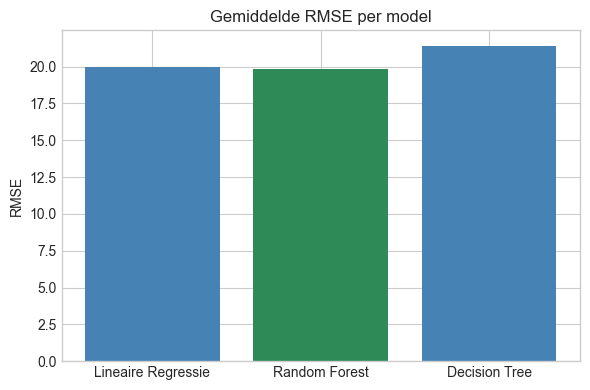

In [86]:
# Plot vergelijking RMSE tussen modellen
plt.figure(figsize=(6, 4))
plt.bar(
    resultaten_cv["Model"], resultaten_cv["Gem. RMSE"], color=["steelblue", "seagreen"]
)
plt.title("Gemiddelde RMSE per model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig('rmse_model.png')
plt.show()

### Observaties resultaten 
Random forest presteert beter dan lineare regressie: R² iets omhoog en RMSE iets omlaag. 
<br>
RMSE van 19.35 is logisch, omdat je populariteit niet alleen op basis van audio features kunt voorspellen. 

<a id="feat_imp"></a>
## 5.4 Feature Importances lineaire regressie en random forest regressor 
Hier worden de belangrijkse features van de lineaire regressie en random forest regressor bekeken na het modellen.

### Feature names functie 

In [87]:
def get_feature_names_from_column_transformer(ct):
    """
    Geeft alle feature-namen terug uit een ColumnTransformer, inclusief nested Pipelines
    en custom transformers.
    """
    feature_names = (
        []
    )  # lijst waar alle namen van getransformeerde features verzameld worden

    # Loop over alle transformers in de ColumnTransformer
    for name, trans, cols in ct.transformers_:
        if (
            trans == "drop"
        ):  # als een transformer ingesteld is om kolommen te verwijderen ('drop'), word die stap overgeslagen
            continue

        # Als de transformer een pipeline is, neem de laatste stap uit de pipeline
        if isinstance(trans, Pipeline):
            last_step = trans[-1]

            # Controleer of de laatste stap zelf feature-namen kan genereren
            if hasattr(last_step, "get_feature_names_out"):
                try:
                    names = last_step.get_feature_names_out(
                        cols
                    )  # probeer namen op te halen
                except Exception:
                    names = [
                        f"{name}__{c}" for c in cols
                    ]  # als het niet lukt, maak zelf unieke namen aan
            else:
                # als de laatste stap geen methode heeft gebruik ook fallback
                names = [f"{name}__{c}" for c in cols]

            feature_names.extend(names)  # voeg namen toe aan de lijst

        # Als het geen pipeline is maar wel een transformer die namen kan geven
        elif hasattr(trans, "get_feature_names_out"):
            try:
                feature_names.extend(trans.get_feature_names_out(cols))
            except Exception:
                feature_names.extend(
                    [f"{name}__{c}" for c in cols]
                )  # fallback als ophalen mislukt
        # Anders: maak zelf simpele namen met stapnaam+kolomnaam
        else:
            feature_names.extend([f"{name}__{c}" for c in cols])

    return feature_names  # geef volledige lijst met feature namen terug

<a id="feat_imp_visualisaties_lineair"></a>
### 5.4.1 Visualisaties Feature Importances Lineair Regression 

Aantal coëfficiënten: 19, aantal feature_names: 18


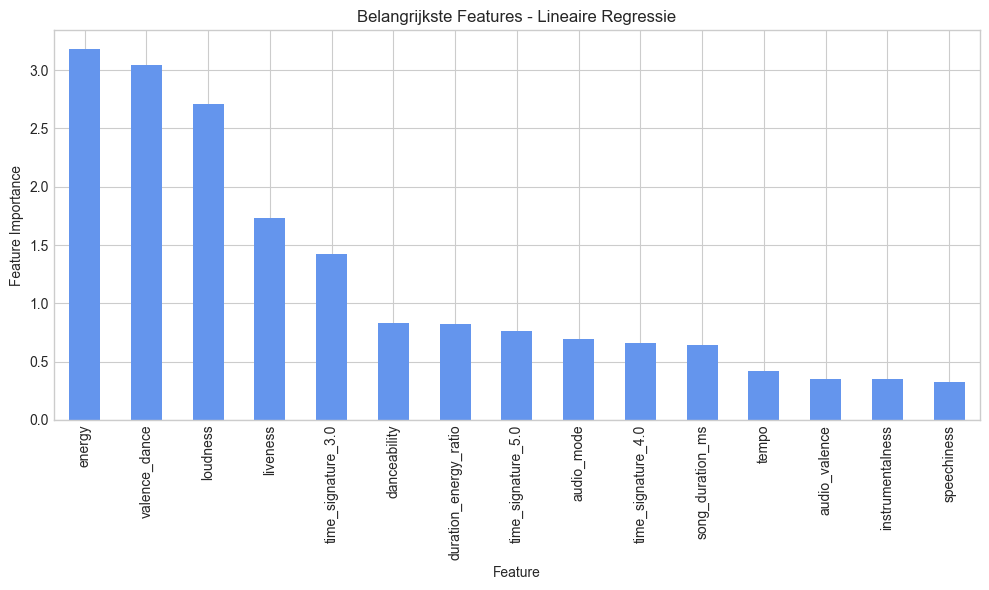

energy                   3.181972
valence_dance            3.043015
loudness                 2.714148
liveness                 1.729852
time_signature_3.0       1.423295
danceability             0.829144
duration_energy_ratio    0.825309
time_signature_5.0       0.765483
audio_mode               0.694823
time_signature_4.0       0.657812
song_duration_ms         0.642673
tempo                    0.420316
audio_valence            0.351621
instrumentalness         0.347039
speechiness              0.327532
acoustic_dance_ratio     0.212960
acousticness             0.069667
key_cyclisch__key        0.023736


In [88]:
# Haal model en preprocessor op uit de pipeline
lineair.fit(X_train, y_train)
model = lineair.named_steps["model"]
preprocessor_final = lineair.named_steps["preprocess"]

# Feature namen ophalen uit de ColumnTransformer
feature_names = get_feature_names_from_column_transformer(preprocessor_final)

# Coëfficiënten als "feature importances" beschouwen
importances = np.abs(model.coef_)  # absolute waarde om sterkte van invloed te meten

# Controleer of de lengte klopt
if len(importances) != len(feature_names):
    print(
        f"Aantal coëfficiënten: {len(importances)}, aantal feature_names: {len(feature_names)}"
    )
    min_len = min(len(importances), len(feature_names))
    importances = importances[:min_len]
    feature_names = feature_names[:min_len]

# Maak pandas Series van de importances met de feature-namen als index
feat_importance_lineair = pd.Series(importances, index=feature_names).sort_values(
    ascending=False
)

# Plot top 15 belangrijke features
plt.figure(figsize=(10, 6))
feat_importance_lineair.head(15).plot(kind="bar", color="cornflowerblue")
plt.title("Belangrijkste Features - Lineaire Regressie")
plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.savefig("feat_importance_lineair_v2_features")
plt.show()

print(feat_importance_lineair.to_string())

In [89]:
print(feat_importance_lineair.to_string())

energy                   3.181972
valence_dance            3.043015
loudness                 2.714148
liveness                 1.729852
time_signature_3.0       1.423295
danceability             0.829144
duration_energy_ratio    0.825309
time_signature_5.0       0.765483
audio_mode               0.694823
time_signature_4.0       0.657812
song_duration_ms         0.642673
tempo                    0.420316
audio_valence            0.351621
instrumentalness         0.347039
speechiness              0.327532
acoustic_dance_ratio     0.212960
acousticness             0.069667
key_cyclisch__key        0.023736


<a id="feat_imp_visualisaties_forest"></a>
### 5.4.2 Visualisaties Feature Importances Random Forest Regressor

Aantal feature_importances: 19, aantal feature_names: 18


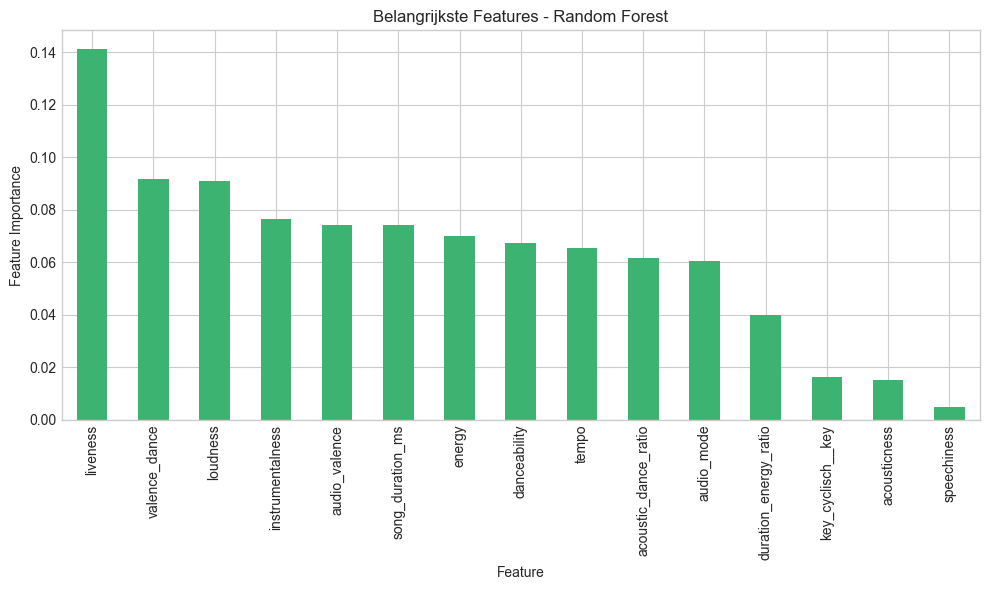

In [90]:
model = grid_search.best_estimator_.named_steps[
    "model"
]  # Haal random forest op uit getrainde gridsearch
importances = model.feature_importances_  # haal de feature importances op
preprocessor_final = grid_search.best_estimator_.named_steps[
    "preprocess"
]  # haal de preprocessor op
feature_names = get_feature_names_from_column_transformer(
    preprocessor_final
)  # gebruik feature names functie om de featurenamen op te halen

# Voorkomt dat Python een error gooit bij het samenvoegen wanneer features verloren gaan of extra dummy's toegevoegd worden
if len(importances) != len(feature_names):
    print(
        f"Aantal feature_importances: {len(importances)}, aantal feature_names: {len(feature_names)}"
    )
    min_len = min(len(importances), len(feature_names))
    importances = importances[:min_len]
    feature_names = feature_names[:min_len]

# Maak pandas Series van de importances met de feature-namen als index
feat_importance_forest = pd.Series(importances, index=feature_names).sort_values(
    ascending=False
)

# Plot top 15 belangrijke features
plt.figure(figsize=(10, 6))
feat_importance_forest.head(15).plot(kind="bar", color="mediumseagreen")
plt.title("Belangrijkste Features - Random Forest")
plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.savefig("feature_importances_forest_v2_features.png")
plt.show()

In [91]:
print(feat_importance_forest.to_string())

liveness                 0.141204
valence_dance            0.091730
loudness                 0.090925
instrumentalness         0.076543
audio_valence            0.074297
song_duration_ms         0.074270
energy                   0.070004
danceability             0.067328
tempo                    0.065405
acoustic_dance_ratio     0.061795
audio_mode               0.060681
duration_energy_ratio    0.039813
key_cyclisch__key        0.016160
acousticness             0.015255
speechiness              0.005033
time_signature_4.0       0.001455
time_signature_3.0       0.001119
time_signature_5.0       0.000089


<a id="regularisatie_modellen"></a>
# Phase 6: Regularisatie modellen

_(Dit is geen officiële CRISP-DM fase, maar voor overzicht in deze notebook aangemaakt)_
<br>
<br>
In deze fase ga ik onderzoeken of regularisatie de prestaties kan verbeteren. 

<a id="regularized_models"></a>
## 6.1 Regularized Regression Models - Ridge, Lasso & ElasticNet

Opzet pipelines regularized regression models, met dezelfde preprocessing-pipeline als eerder, incl. hyperparameter tuning.
<br>
In 6.2 volgt de training, validatie en evaluatie 

In [92]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Pipelines met dezelfde preprocessing als eerder
ridge_pipe = Pipeline(
    [
        ("feature_creation", feature_engineering),
        ("clean_outliers", OutlierCleaner()),
        ("preprocess", preprocessor),
        ("model", Ridge(random_state=42)),
    ]
)

lasso_pipe = Pipeline(
    [
        ("feature_creation", feature_engineering),
        ("clean_outliers", OutlierCleaner()),
        ("preprocess", preprocessor),
        ("model", Lasso(max_iter=2000, random_state=42)),
    ]
)

elastic_pipe = Pipeline(
    [
        ("feature_creation", feature_engineering),
        ("clean_outliers", OutlierCleaner()),
        ("preprocess", preprocessor),
        ("model", ElasticNet(max_iter=2000, random_state=42)),
    ]
)

# Hyperparameter grids
param_grid_ridge = {"model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {"model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_elastic = {
    "model__alpha": [0.001, 0.01, 0.1, 1.0],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# GridSearch voor elk model
grids = {
    "Ridge": GridSearchCV(
        ridge_pipe, param_grid_ridge, scoring="r2", cv=5, n_jobs=-1, verbose=1
    ),
    "Lasso": GridSearchCV(
        lasso_pipe, param_grid_lasso, scoring="r2", cv=5, n_jobs=-1, verbose=1
    ),
    "ElasticNet": GridSearchCV(
        elastic_pipe, param_grid_elastic, scoring="r2", cv=5, n_jobs=-1, verbose=1
    ),
}

<a id="regularized_models_eval"></a>
## 6.2 Evaluatie en Resultaten Regularized Modellen 

In [93]:
best_models = {}
for name, grid in grids.items():
    print(f"\nGrid search voor {name}")
    grid.fit(X_train, y_train)
    print("Beste parameters:", grid.best_params_)
    print("Beste CV R²:", round(grid.best_score_, 4))
    best_models[name] = grid.best_estimator_

# Evaluatie op testdata
result_rows = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    result_rows.append([name, r2, rmse])

# Resultatentabel
resultaten_regularisatie = pd.DataFrame(
    result_rows, columns=["Model", "R²", "RMSE"]
).round({"R²": 4, "RMSE": 2})
display(resultaten_regularisatie)


Grid search voor Ridge
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Beste parameters: {'model__alpha': 100}
Beste CV R²: 0.0285

Grid search voor Lasso
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Beste parameters: {'model__alpha': 0.01}
Beste CV R²: 0.0285

Grid search voor ElasticNet
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Beste parameters: {'model__alpha': 0.01, 'model__l1_ratio': 0.1}
Beste CV R²: 0.0285


,Model,R²,RMSE
0,Ridge,0.0172,20.31
1,Lasso,0.0173,20.31
2,ElasticNet,0.0172,20.31


In [94]:
# Combineer baseline- en regularized modelresultaten
resultaten_opslaan = []
if "resultaten" in locals():
    resultaten_opslaan.append(resultaten.copy())

if "resultaten_regularisatie" in locals():
    resultaten_opslaan.append(resultaten_regularisatie.copy())

if not resultaten_opslaan:
    raise ValueError("Geen nieuwe resultaten om op te slaan")

huidige_resultaten = pd.concat(resultaten_opslaan, ignore_index=True)

<a id="eval_samenvatting_ref"></a>
# Phase 7: Evaluatie, samenvatting en reflectie 
_(Dit is niet een officiële CRISP-DM fase, maar aangemaakt door mij voor overzicht)_

<a id="eval_reflectie"></a>
## 7.1 Evaluatie en Reflectie 

Hoewel Random Forest iets beter scoort dan de lineaire modellen (R² ≈ 0.07), blijft de voorspellingskracht laag.  
<br>
De lineaire modellen scoren vergelijkbaar, zelfs met regularisatie.
<br>
<br>
Populaire liedjes worden waarschijnlijk beïnvloed door externe factoren zoals marketing, artiestenbekendheid en culturele trends.
<br>
<br>
Audiofeatures alleen zijn dus onvoldoende om populariteit betrouwbaar te voorspellen.

#### Reflectie 
Om populariteit beter te voorspellen, zouden aanvullende features nodig zijn, zoals releasejaar, artiestenpopulariteit, playlistplaatsing of social media-activiteit.  
<br>
Audio alleen geeft slechts een klein deel van het verhaal weer.

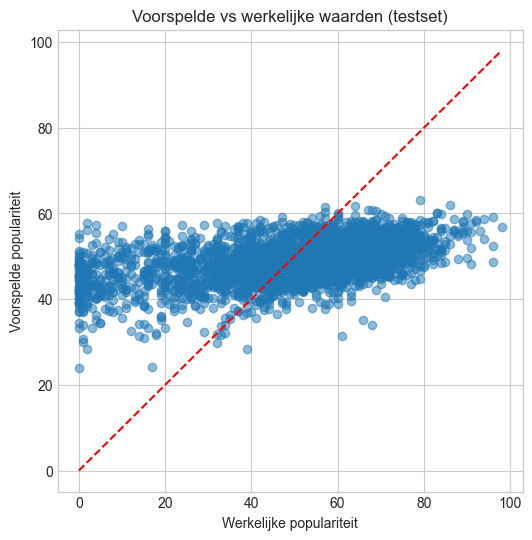

In [95]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Werkelijke populariteit")
plt.ylabel("Voorspelde populariteit")
plt.title("Voorspelde vs werkelijke waarden (testset)")
plt.savefig("voorspeld_vs_werkelijk_v2_features")
plt.show()

<a id="resultaten"></a>
## 7.3 Resultaten opslaan en combineren 
Hier worden alle resultaten van de modeltrainingen opgeslagen en gecombineerd, waarna er 2 nieuwe csv's aangemaakt worden; model_resultaten en alle_model_resultaten.

In [96]:
# !! Pas dit aan bij elke nieuwe run !!
experiment = "v2_features"

# Combineer resultaten van beide sets (baseline + lineair)
resultaten_lijst = []
if "resultaten" in locals():
    resultaten_lijst.append(resultaten.copy())
if "resultaten_regularisatie" in locals():
    resultaten_lijst.append(resultaten_regularisatie.copy())

if not resultaten_lijst:
    raise ValueError("Geen resultaten gevonden om op te slaan")

huidige_resultaten = pd.concat(resultaten_lijst, ignore_index=True)

# Datum/tijd toevoegen
timestamp = datetime.now().strftime("%d-%m-%Y %H:%M")
huidige_resultaten["Versie"] = experiment
huidige_resultaten["Datum"] = timestamp

# 4. Zorg dat de modellen in vaste volgorde staan
volgorde = [
    "Lineaire Regressie",
    "Decision Tree Regressor",
    "Random Forest",
    "Ridge",
    "Lasso",
    "ElasticNet",
    "DummyRegressor (mean)",
]
huidige_resultaten["Model"] = pd.Categorical(
    huidige_resultaten["Model"], categories=volgorde, ordered=True
)
huidige_resultaten = huidige_resultaten.sort_values("Model").reset_index(drop=True)

# 5. Sla resultaten van deze run op
bestandsnaam = f"model_resultaten_{experiment}.csv"
huidige_resultaten.to_csv(bestandsnaam, index=False)
print(f"Resultaten opgeslagen als: {bestandsnaam}")

# 6. Combineer alle bestaande resultaten
bestanden = [f for f in glob.glob("model_resultaten_*.csv") if f.endswith(".csv")]
alle_resultaten = pd.concat([pd.read_csv(f) for f in bestanden], ignore_index=True)

# 7. Verwijder lege of missende regels
alle_resultaten = alle_resultaten.dropna(subset=["Model"])
alle_resultaten = alle_resultaten[
    alle_resultaten["Model"].astype(str).str.strip() != ""
]

# 8. Zet datum om en sorteer van oud → nieuw
alle_resultaten["Datum"] = pd.to_datetime(
    alle_resultaten["Datum"], format="%d-%m-%Y %H:%M"
)
alle_resultaten = alle_resultaten.sort_values("Datum", ascending=True).reset_index(
    drop=True
)
alle_resultaten["Datum"] = alle_resultaten["Datum"].dt.strftime("%d-%m-%Y %H:%M")

# 9. Opslaan en tonen
alle_resultaten.to_csv("alle_model_resultaten.csv", index=False)
display(alle_resultaten)
print("Totaaloverzicht opgeslagen als: alle_model_resultaten.csv")

Resultaten opgeslagen als: model_resultaten_v2_features.csv


,Model,R²,RMSE,Versie,Datum
0,Lineaire Regressie,0.0234,19.80,v1_baseline,31-10-2025 17:39
1,Decision Tree Regressor,-0.1190,21.19,v1_baseline,31-10-2025 17:39
2,Random Forest,0.0670,19.35,v1_baseline,31-10-2025 17:39
3,Ridge,0.0234,19.80,v1_baseline,31-10-2025 17:39
4,Lasso,0.0234,19.80,v1_baseline,31-10-2025 17:39
5,ElasticNet,0.0234,19.80,v1_baseline,31-10-2025 17:39
6,DummyRegressor (mean),-0.0000,20.03,v1_baseline,31-10-2025 17:39
7,Lineaire Regressie,0.0173,20.31,v2_features,01-11-2025 23:25
8,Decision Tree Regressor,-0.1077,21.57,v2_features,01-11-2025 23:25
9,Random Forest,0.1668,18.70,v2_features,01-11-2025 23:25


Totaaloverzicht opgeslagen als: alle_model_resultaten.csv


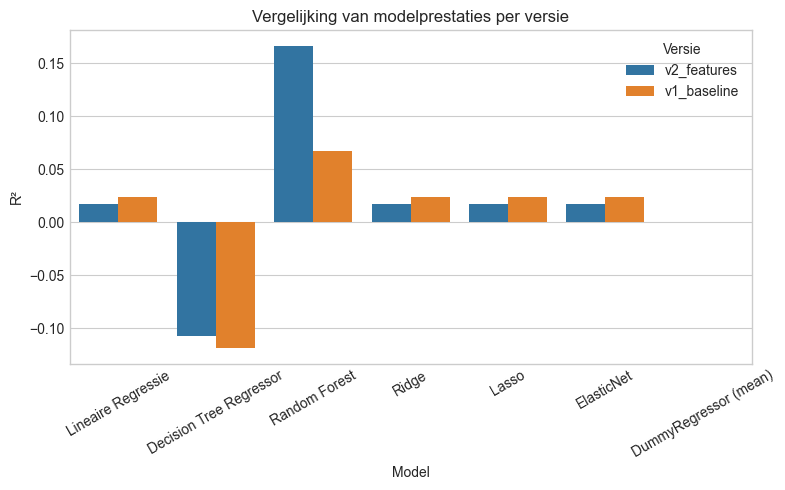

In [97]:
# Lees alle model_resultaten-bestanden
bestanden = glob.glob("model_resultaten_*.csv")
df = pd.concat([pd.read_csv(f) for f in bestanden], ignore_index=True)

# Plot vergelijking tussen versies
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Model", y="R²", hue="Versie")
plt.title("Vergelijking van modelprestaties per versie")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [98]:
# Voeg versie en timestamp toe
folds_df["Versie"] = experiment
folds_df["Datum"] = datetime.now().strftime("%d-%m-%Y %H:%M")

# Sla per-run folds op
folds_df.to_csv(f"fold_scores_{experiment}.csv", index=False)
print(f"Foldscores opgeslagen als: fold_scores_{experiment}.csv")

Foldscores opgeslagen als: fold_scores_v2_features.csv
